In [1]:
# import the module for simulating data
from statsmodels.tsa.arima_process import ArmaProcess 
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid
from sklearn.preprocessing import MinMaxScaler

In [2]:
def varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    return dot(Phi, R)


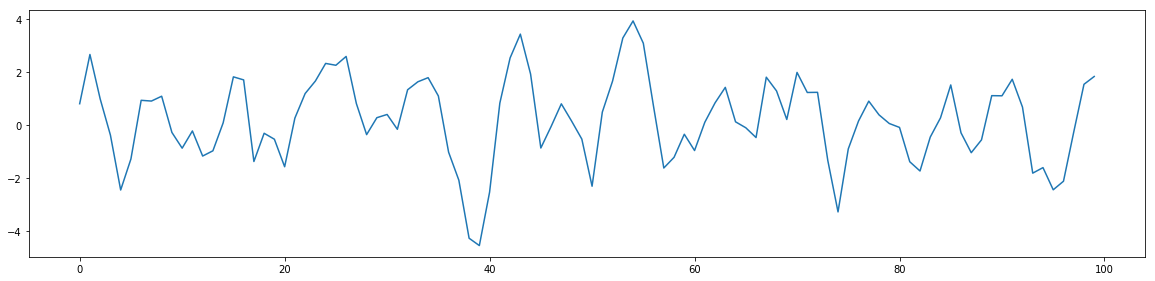

In [3]:
# import the module for simulating data
#from statsmodels.tsa.arima_process import ArmaProcess
plt.figure(figsize=(20,10))

# Plot 1: AR parameter = +0.9
plt.subplot(2,1,1)
ar1 = np.array([1,-0.9,0.5])
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = AR_object1.generate_sample(nsample=100)
plt.plot(simulated_data_1);


In [135]:
data_ts = np.zeros((60,25))

In [136]:
ma1 = np.array([1])
ar1 = np.array([1,0.05])
for i in range(25):
   # if (i % 5) == 0: 
   #     ar1 = np.array([1,0.4 * i])
    
    AR_object1 = ArmaProcess(ar1, ma1)
    simulated_data_1 = AR_object1.generate_sample(nsample=60)
    data_ts[:,i] = simulated_data_1

In [3]:
def uni_deseasonalize(ts,freq=12):
    ts = np.array(ts)
    N = len(ts)
    #averages = np.zeros((freq,n))
    temp = ts
    result = np.zeros((N))
    for j in range(freq):
        Idx = np.arange(j,N,freq)
        result[Idx] = temp[Idx] - temp[Idx].mean()
    return(result) 

In [126]:
def deseasonalize(data,freq=12):
    n  = data.shape[1]
    N  = data.shape[0]
    averages = np.zeros((freq,n))
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = data[:,i]
        result = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            averages[j,i] = temp[Idx].mean()
            result[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
        data_deseasonal[:,i] = result
    return(data_deseasonal) 

In [216]:
data = np.load('data.npy')
lat = np.load('lat.npy')
lon = np.load('lon.npy')

In [217]:
result = []
index = []
lat_list = []
lon_list =[]
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if not data[i,j,-1] < 0:
            result.append(data[i,j,:])
            index.append((i,j))
            lon_list.append(lon[i])
            lat_list.append(lat[j])

In [218]:
result = deseasonalize(np.array(result))

In [219]:
result = np.matrix(result)
result = result.transpose()
data = pd.DataFrame(result)

In [220]:
scale = StandardScaler()
scaled_data = scale.fit_transform(data)

In [221]:
pca = PCA(n_components=7)
pca_model = pca.fit(scaled_data)

In [222]:
pca_data = pca_model.transform(data)

In [223]:
Matrix = pd.DataFrame(pca_model.components_)
Matrix1 = np.transpose(Matrix)

In [224]:
Matrix1 = Matrix1/Matrix1.sum()

In [225]:
loading = pd.DataFrame(varimax(Matrix1, q=200))
loading = loading.abs()

In [238]:
def index_finder(loading,col,percent = 0.98):
    values = loading[col].sort_values(ascending = False)
    s = 0
    i = 0
    while s < percent:
        s+=values[i]
        i = i+1
    Idx = values[:i].index
    return(Idx)

In [250]:
Idx = index_finder(loading,3)

In [241]:
clusters = loading.idxmax(axis=1)
df = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clusters.values.tolist()})

In [251]:
df1 = df.iloc[Idx,:]

In [144]:
colors = {0:'b', 1:'g', 2:'r', 3:'c', 4:'m', 5:'y',6:'k'}
label_color = np.array([colors[l] for l in clusters.values])
center_colors = label_color[:len(clusters)]

In [211]:
lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"].vlues = lon_temp

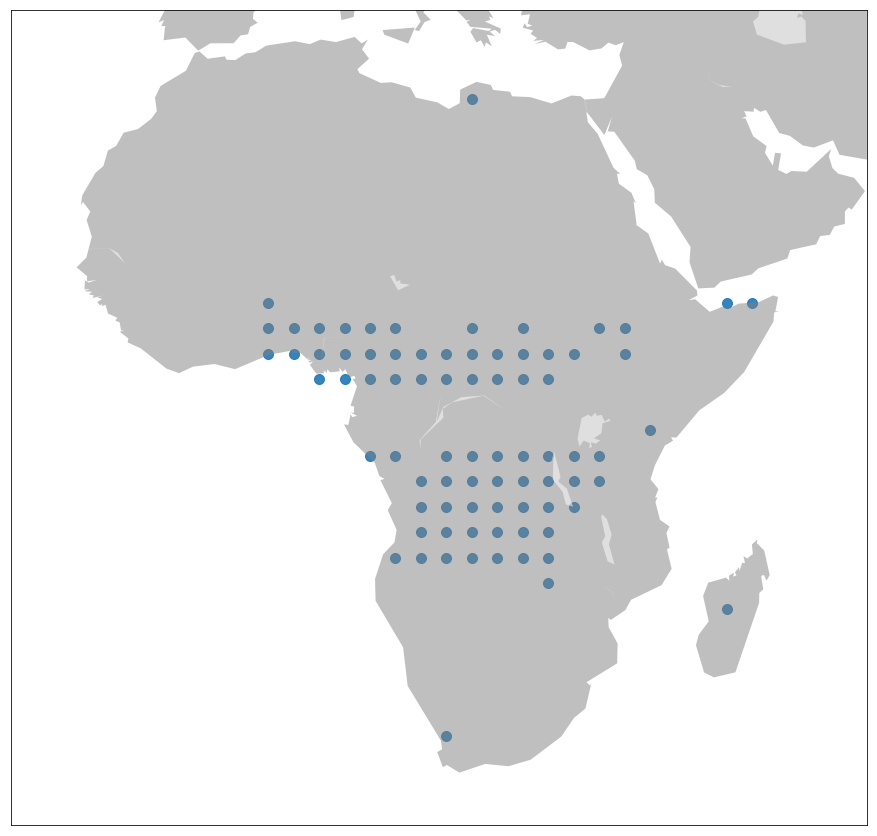

In [252]:
#lon = np.arange(-23.75,60.0,2.5)
fig = plt.figure(figsize=(30,15))
# setup Lambert Conformal basemap.
#m = Basemap(projection='cyl',
#              llcrnrlon=lon[0], 
#              llcrnrlat=lat[-1], 
#              urcrnrlon=lon[-1], 
#              urcrnrlat=lat[0],resolution='c')
#m = Basemap(projection='cyl', \
#            llcrnrlat=-90, urcrnrlat=90, \
#            llcrnrlon=-180, urcrnrlon=180, \
#            lat_ts=20, \
#            resolution='c')
m=Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
# draw coastlines.
m.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines()
# draw a boundary around the map, fill the background.
# this background will end up being the ocean color, since
# the continents will be drawn on top.
#m.drawmapboundary(fill_color='white')
#m.bluemarble()
# fill continents, set lake color same as ocean color.
#m.fillcontinents(color='lightgrey',lake_color='white', )
#m.drawlsmask(land_color='coral',ocean_color='aqua',lakes=True)

lons = df1["lons"].values
lats = df1["lats"].values
x,y = m(lons, lats)
plt.scatter(x, y, alpha=0.9, s=100)

#lons2 = df2["lons"]
#lats2 = df2["lats"]
#x,y = m(lons2, lats2)
#m.scatter(x, y)

#lons3 = df3["lons"]
#lats3 = df3["lats"]
#x,y = m(lons3, lats3)
#m.scatter(x, y)

#lons3 = df3["lons"]
#lats3 = df3["lats"]
#x,y = m(lons3, lats3)
#m.scatter(x, y)

plt.show()

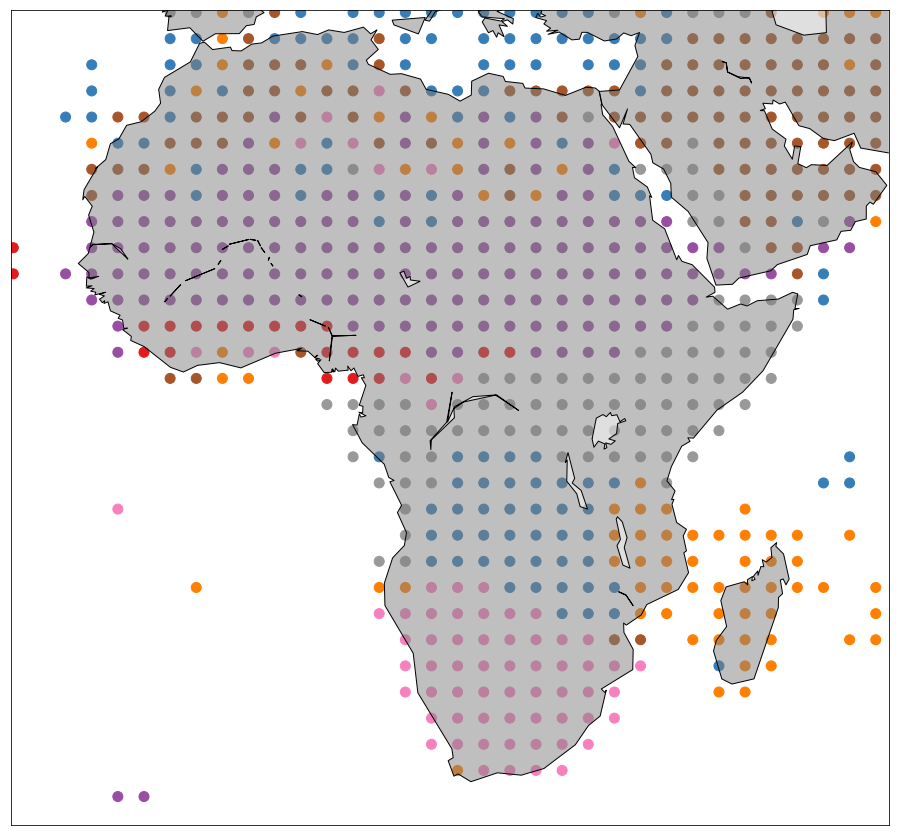

In [150]:
plt.figure(figsize=(30,15))
# Make the background map
m=Basemap(llcrnrlon=-24, llcrnrlat=-39,urcrnrlon=60,urcrnrlat=39)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")
m.drawcoastlines()
lons = df["lons"].values
lats = df["lats"].values
x,y = m(lons, lats)
#plt.scatter(x, y, c=df["clusters"], s=50)
# prepare a color for each point depending on the continent.
df['labels_enc'] = pd.factorize(df["clusters"])[0]
 
# Add a point per position
m.scatter(x, y,  alpha=50, c=df['labels_enc'], cmap="Set1", s=100)
 

In [273]:
lon = np.arange(-178.75,179.0,2.5)
lat = np.arange(-88.75,89,2.5)

In [28]:
lon = np.arange(-23.75,60.0,2.5)
lat = np.arange(-40,40,2.5)

In [279]:
deg = np.zeros((len(lat),len(lon)))

In [280]:
lat_number = deg.shape[0]
lon_number = deg.shape[1]

In [281]:
for i in range(lat_number):
    for j in range(lon_number):
        if not df[(df.lats == lat[i]) & (df.lons == lon[j])].clusters.values.size == 0:
            deg[i,j] = df[(df.lats == lat[i]) & (df.lons == lon[j])].clusters.values
        else:
            deg[i,j]=np.nan

In [268]:
deg = np.flip(deg, axis=0)

In [255]:
lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"].vlues = lon_temp

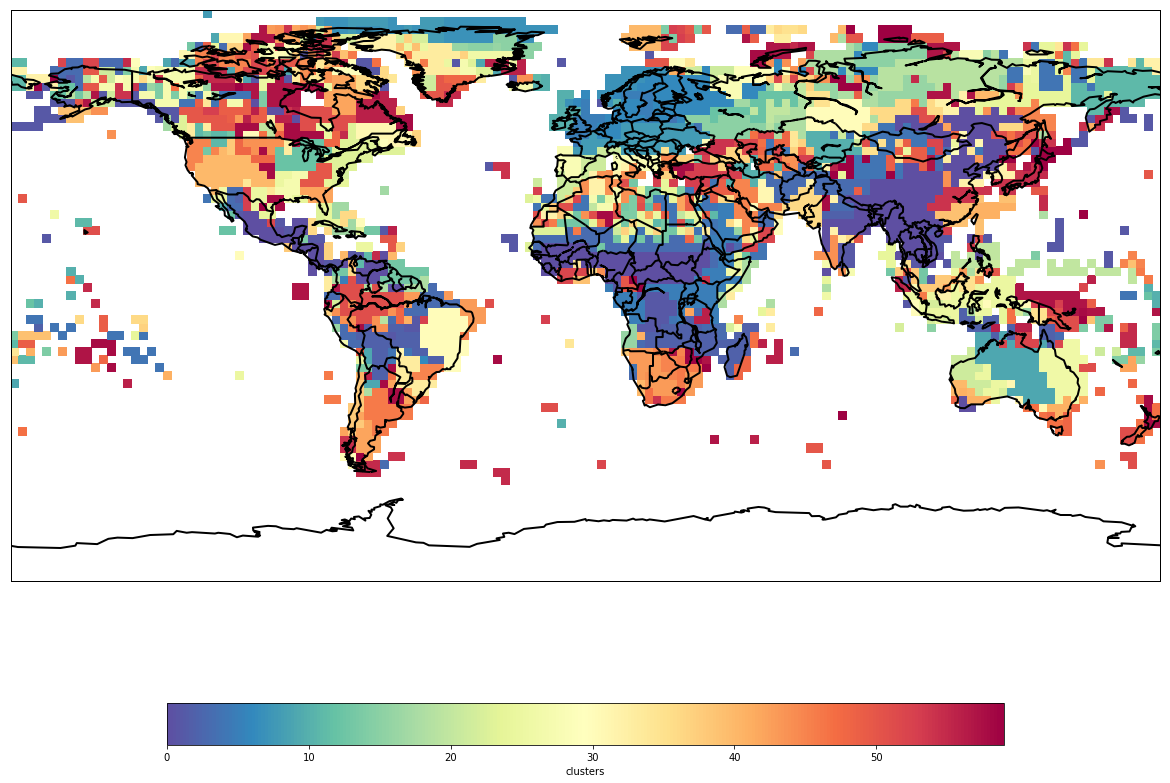

In [282]:
plt.figure(figsize=(30,15))

map = Basemap(projection='cyl',
              llcrnrlon=lon[0], 
              llcrnrlat=lat[0], 
              urcrnrlon=lon[-1], 
              urcrnrlat=lat[-1])

map.drawmapboundary()
map.drawcoastlines(linewidth=2)
map.drawcountries(linewidth=2)

#x = linspace(0, lon[-1]+1, deg.shape[1])
#y = linspace(0, lat[-1]+1, deg.shape[0])

xx, yy = meshgrid(lon, lat)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
cbar.set_label('clusters')
#plt.title("Degree Centrality", fontsize=16)
#plt.savefig('degree-centrality .eps')
plt.show()

In [204]:
f_pre = Dataset('world_precipitation.nc')
data = f_pre.variables['precip']
lon = f_pre.variables['lon'][:]
lat = f_pre.variables['lat'][:]
time = f_pre.variables['time'][:]
data = np.swapaxes(data,0,2)

In [205]:
result = []
index = []
lat_list = []
lon_list =[]
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if not data[i,j,-1] < 0:
            result.append(data[i,j,:])
            index.append((i,j))
            lon_list.append(lon[i])
            lat_list.append(lat[j])

result = deseasonalize(np.array(result))

result = np.matrix(result)
result = result.transpose()
data = pd.DataFrame(result)

scale = StandardScaler()
scaled_data = scale.fit_transform(data)

pca = PCA(n_components=60)
pca_model = pca.fit(scaled_data)

pca_data = pca_model.transform(data)

Matrix = pd.DataFrame(pca_model.components_)
Matrix1 = np.transpose(Matrix)

#Matrix1 = Matrix1/Matrix1.sum()

loading = pd.DataFrame(varimax(Matrix1, q=200))
#loading = pd.DataFrame(Matrix1)
loading = loading.abs()
clusters = loading.idxmax(axis=1)
df = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clusters.values.tolist()})

In [209]:
lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"].vlues = lon_temp

In [131]:
#lon = np.arange(-178.75,179.0,2.5)
#lat = np.arange(-88.75,89,2.5)

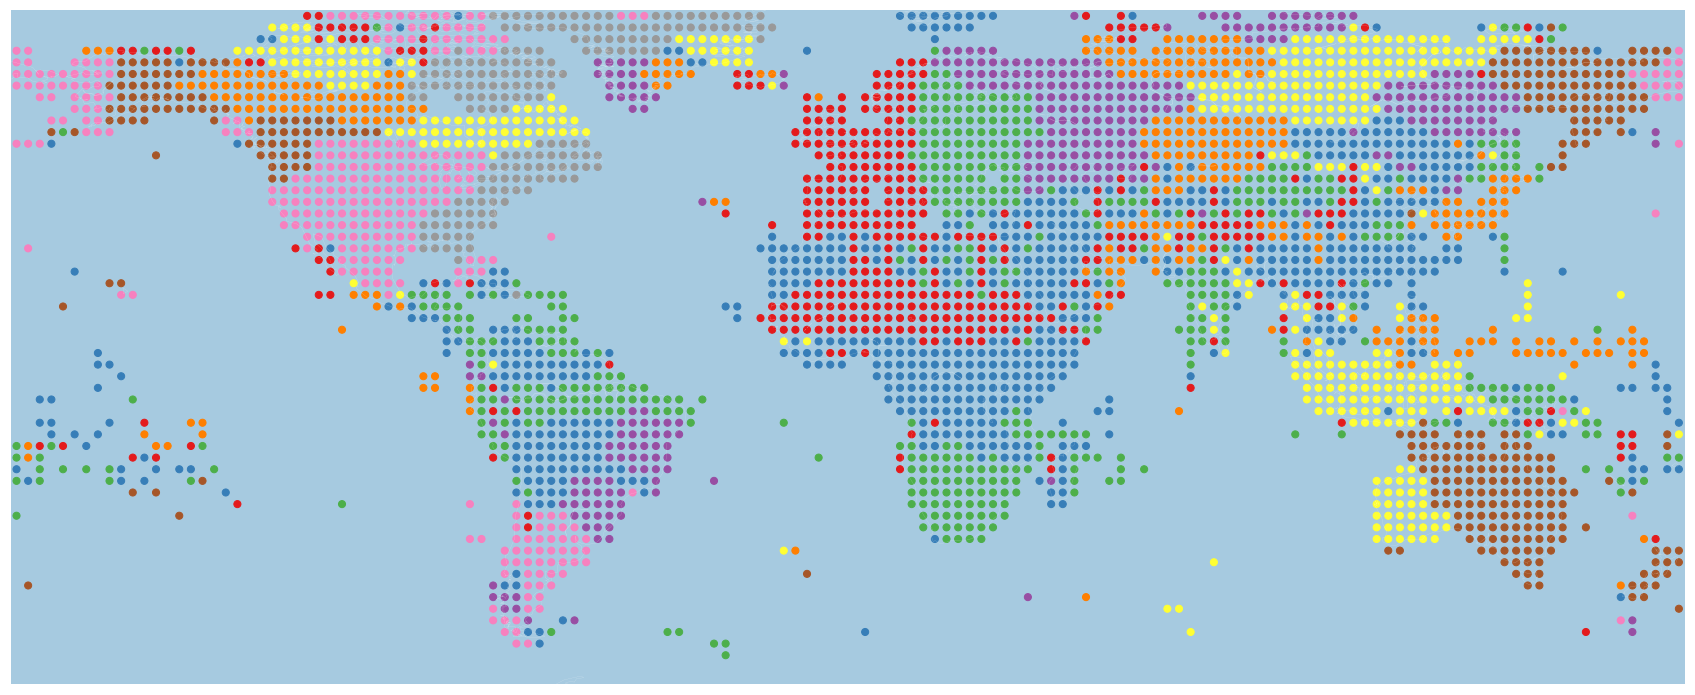

In [210]:
plt.figure(figsize=(30,15))
# Make the background map
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
#m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")
                 
lons = df["lons"].values
lats = df["lats"].values
x,y = m(lons, lats)
#plt.scatter(x, y, c=df["clusters"], s=50)
# prepare a color for each point depending on the continent.
df['labels_enc'] = pd.factorize(df["clusters"])[0]
 
# Add a point per position
m.scatter(x, y,  alpha=50, c=df['labels_enc'], cmap="Set1",s=50, )

#ax = plt.gca()
#handles, labels = ax.get_legend_handles_labels()
#legend1 = ax.legend(m.scatter.legend_elements,loc="lower left", title="Classes")
#ax.add_artist(legend1)



In [ ]:
lons = df["lons"].values
lats = df["lats"].values
x,y = m(lons, lats)
plt.scatter(x, y, c=df["clusters"], s=50)
# prepare a color for each point depending on the continent.
data['labels_enc'] = pd.factorize(df["clusters"])[0]
 
# Add a point per position
m.scatter(data['homelon'], data['homelat'], s=data['n']/6, alpha=0.4, c=data['labels_enc'], cmap="Set1")

In [19]:
loading = np.matrix(loading)
data = np.matrix(data)

In [20]:
result = np.matmul(data,loading)

In [91]:
AR = np.load("AR.npy")

Text(0.5,1,'Autoregressive Levels')

/home/mathsys2/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:955: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


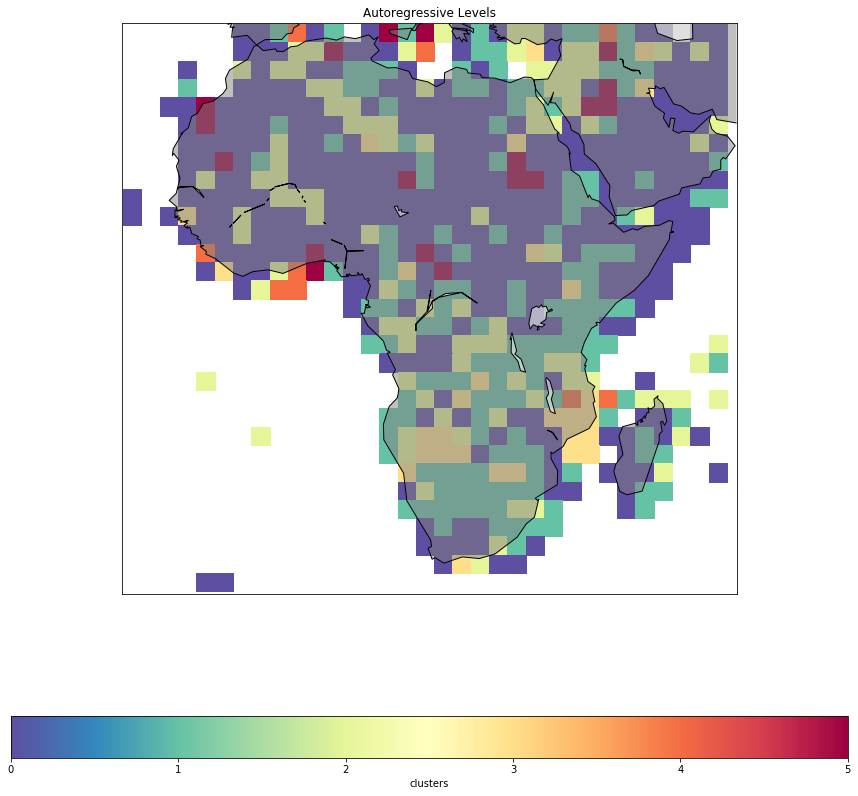

In [92]:
lon = np.arange(-23.75,60.0,2.5)
plt.figure(figsize=(30,15))
# Make the background map
m=Basemap(llcrnrlon=-24, llcrnrlat=-39,urcrnrlon=60,urcrnrlat=39)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")
m.drawcoastlines()
xx, yy = meshgrid(lon, lat)
cs = m.pcolormesh(xx, yy, AR, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
cbar.set_label('clusters')
plt.title("Autoregressive Levels")

In [31]:
AR = np.load("AR.npy")

In [34]:
#ar_flip = np.flip(AR,axis=0)

Text(0.5,1,'Autoregressive Levels')

/home/mathsys2/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:955: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


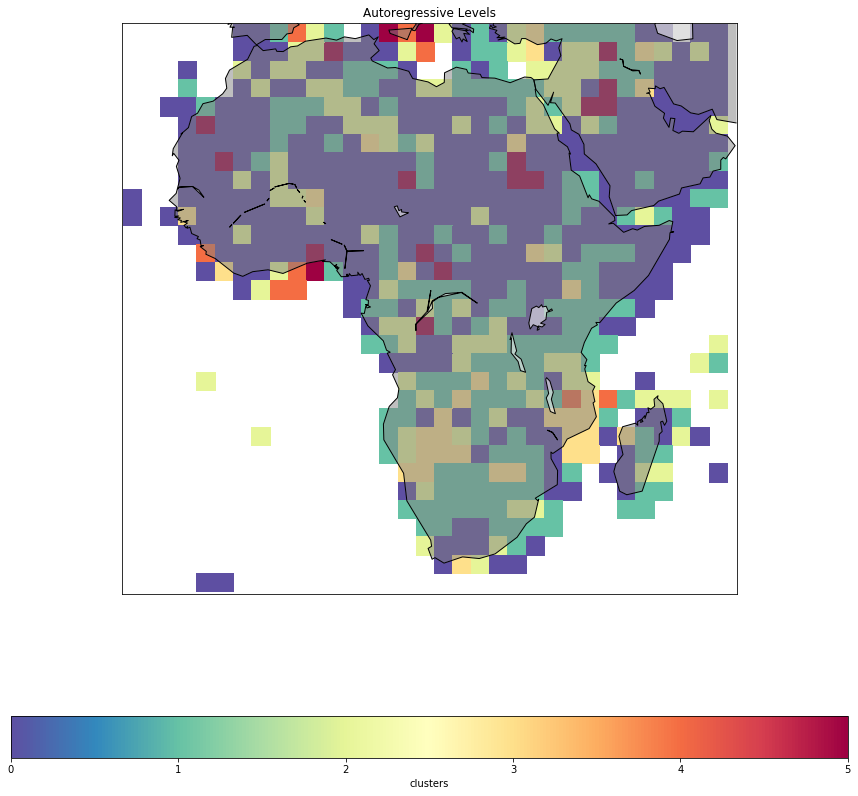

In [47]:
lon = np.arange(-23.75,60.0,2.5)
plt.figure(figsize=(30,15))
# Make the background map
m=Basemap(llcrnrlon=-24, llcrnrlat=-39,urcrnrlon=60,urcrnrlat=39)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")
m.drawcoastlines()
xx, yy = meshgrid(lon, lat)
cs = m.pcolormesh(xx, yy, AR, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
cbar.set_label('clusters')
plt.title("Autoregressive Levels")